# Estimativa de volumes de árvores

Modelos de aprendizado de máquina são bastante usados na área da engenharia florestal (mensuração florestal) para, por exemplo, estimar o volume de madeira de árvores sem ser necessário abatê-las.

O processo é feito pela coleta de dados (dados observados) através do abate de algumas árvores, onde sua altura, diâmetro na altura do peito (dap), etc, são medidos de forma exata. Com estes dados, treina-se um modelo de AM que pode estimar o volume de outras árvores da população.

Os modelos, chamados **alométricos**, são usados na área há muitos anos e são baseados em regressão (linear ou não) para encontrar uma equação que descreve os dados. Por exemplo, o modelo de Spurr é dado por:

$$Volume = b_0 + b_1 * dap ^ 2 * H_t$$

Onde **dap** é o diâmetro na altura do peito (1,3 metros), $H_t$ é a altura total. Tem-se vários modelos alométricos, cada um com uma determinada característica, parâmetros, etc. Um modelo de regressão envolve aplicar os dados observados e encontrar $b_0$ e $b_1$ no modelo apresentado, gerando assim uma equação que pode ser usada para prever o volume de outras árvores.

Dado o arquivo **Volumes.csv**, que contém os dados de observação, escolha um modelo de aprendizado de máquina com a melhor estimativa, a partir da estatística de correlação.

## Tarefas

#### 1. Carregar o arquivo Volumes.csv (http://www.razer.net.br/datasets/Volumes.csv)

In [54]:
dataset <- read.csv('http://www.razer.net.br/datasets/Volumes.csv', header = TRUE, sep = ';', dec = ',')

In [55]:
head(dataset)

NR,DAP,HT,HP,VOL
1,34.0,27.00,1.80,0.8971441
2,41.5,27.95,2.75,1.6204441
3,29.6,26.35,1.15,0.8008181
4,34.3,27.15,1.95,1.0791682
5,34.5,26.20,1.00,0.9801112
6,29.9,27.10,1.90,0.9067022


-----

#### 2. Eliminar a coluna NR, que só apresenta um número sequencial

In [56]:
dataset <- dataset[-1]

In [57]:
head(dataset)

DAP,HT,HP,VOL
34.0,27.00,1.80,0.8971441
41.5,27.95,2.75,1.6204441
29.6,26.35,1.15,0.8008181
34.3,27.15,1.95,1.0791682
34.5,26.20,1.00,0.9801112
29.9,27.10,1.90,0.9067022


----

#### 3. Criar partição de dados: treinamento 80%, teste 20%

In [58]:
library('caret')

In [61]:
indexes <- createDataPartition(dataset$VOL, p = 0.80, list = FALSE)

In [82]:
train_data <- dataset[indexes,]
test_data <- dataset[-indexes,]

-----

#### 4. Usando o pacote "caret", treinar os modelos: Random Forest (rf), SVM (svmRadial), Redes Neurais (neuralnet) e o modelo alométrico de SPURR

#### 5. O modelo alométrico é dado por: Volume = $b_0$ + $b_1$ * $dap ^2$ * $H_t$

##### random forest

In [217]:
rf_model <- train(VOL ~., data = train_data, method = 'rf')

note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



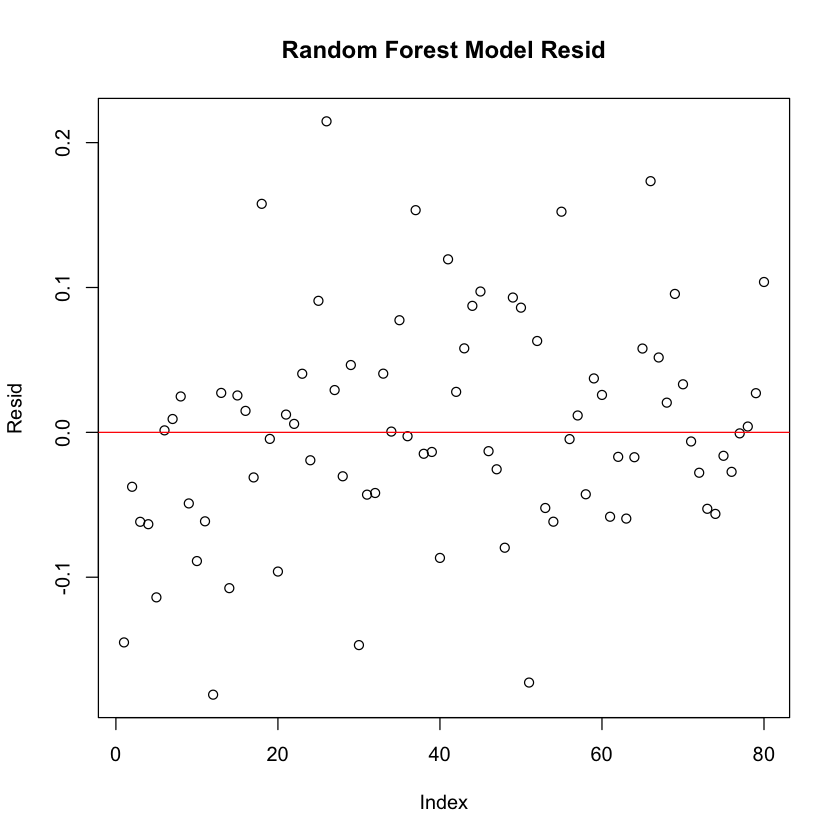

In [309]:
plot(resid(rf_model), ylab = 'Resid', main = 'Random Forest Model Resid')
abline(0, 0, col = 'red')

##### svm

In [214]:
svm_model <- train(VOL ~., data = train_data, method = 'svmRadial')

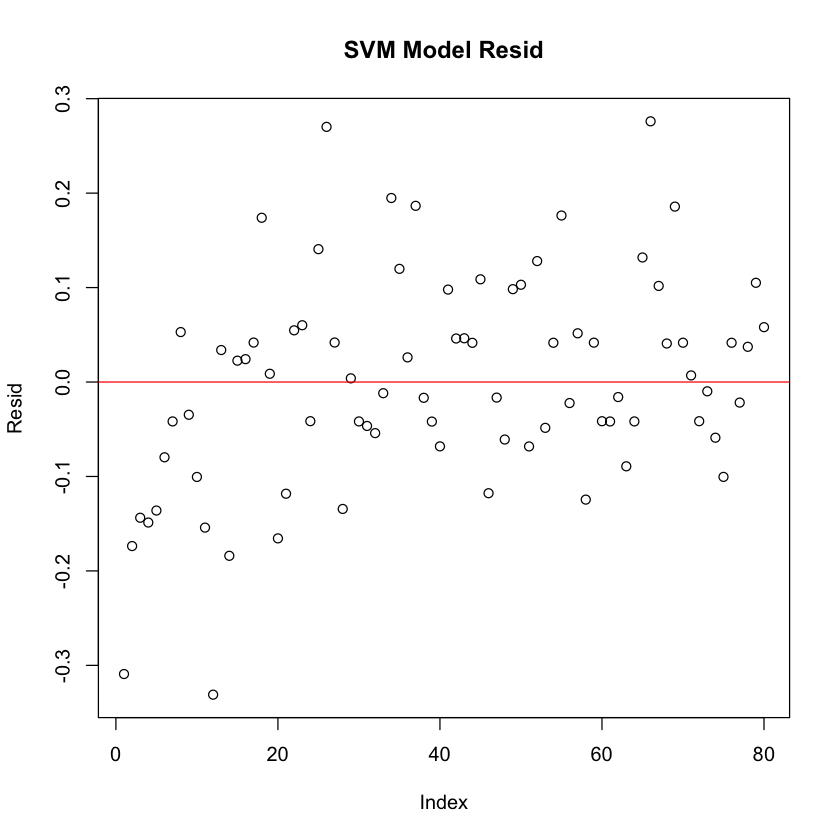

In [269]:
plot(train_data$VOL - predict(svm_model, train_data), ylab = 'Resid', main = 'SVM Model Resid')
abline(0, 0, col = 'red')

##### redes neurais

In [251]:
nn_model <- train(VOL ~ ., data = train_data, method = 'neuralnet', linear.output = TRUE, threshold = 0.1)

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

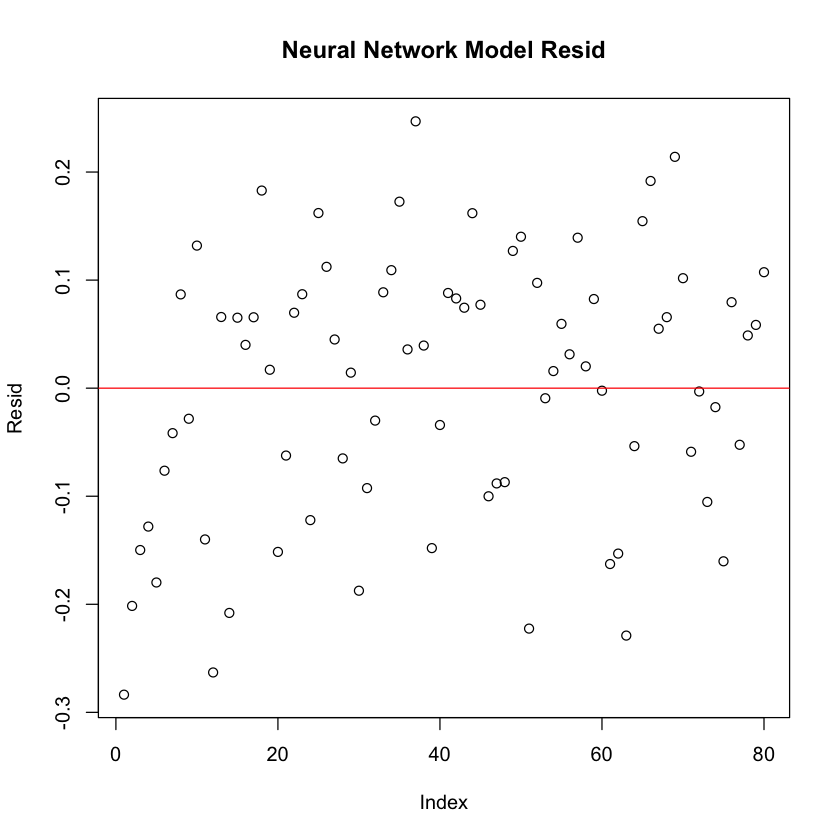

In [271]:
plot(resid(nn_model), ylab = 'Resid', main = 'Neural Network Model Resid')
abline(0, 0, col = 'red')

##### modelo alométrico de SPURR

In [253]:
alom_model <- nls(VOL ~ b0 + b1 * DAP * DAP * HT, train_data, start = list(b0 = 0.5, b1 = 0.5))

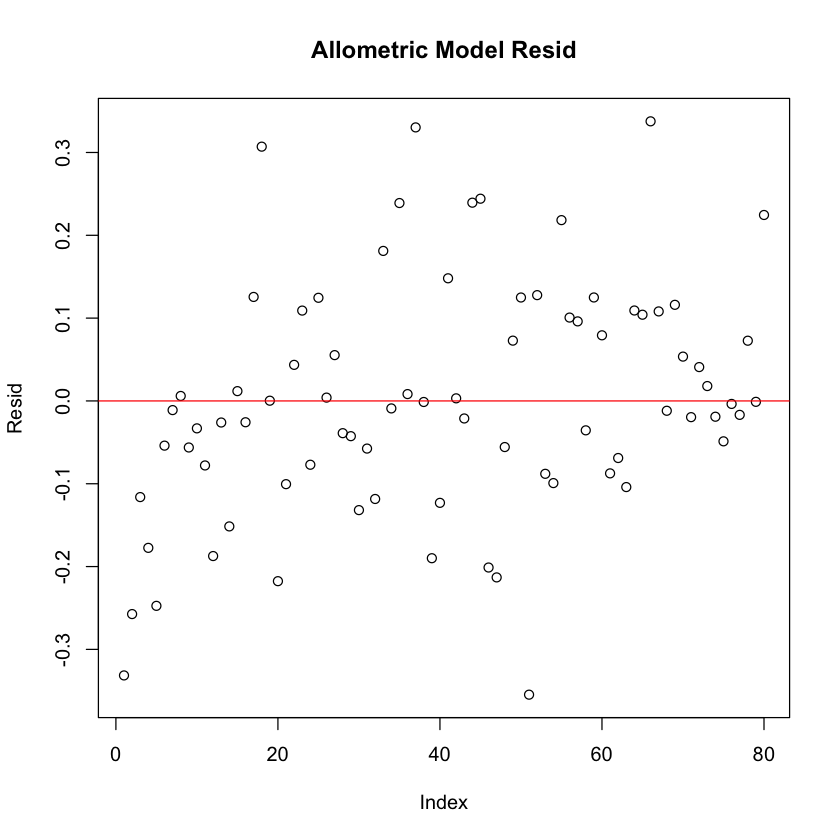

In [273]:
plot(resid(alom_model), ylab = 'Resid', main = 'Allometric Model Resid')
abline(0, 0, col = 'red')

-----

#### 6. Efetue as predições nos dados de teste

In [255]:
rf_predictions <- predict(rf_model, test_data)

In [256]:
svm_predictions <- predict(svm_model, test_data)

In [257]:
nn_predictions <- predict(nn_model, test_data)

In [258]:
alom_predictions <- predict(alom_model, test_data)

-----

#### 7. Crie funções e calcule as seguintes métricas entre a predição e os dados observados

- Coeficiente de determinação: $R^2$

 $$1 - \frac{\sum_{i=1}^n (y_i - \widehat{y_i})^2}{\sum_{i=1}^n (y_i - \overline{y} )^2}$$

onde $y_i$ é o valor observado, $\widehat{y_i}$ é o valor predito e $\overline{y}$ é a média dos valores $y_i$ observados. Quanto mais perto de 1 melhor é o modelo;

- Erro padrão da estimativa: $S_{yx}$

$$S_{yx} = \sqrt{\frac{\sum_{i=1}^n (y_i - \widehat{y_i})^2}{n - 2}}$$

esta métrica indica erro, portanto quanto mais perto de 0 melhor é o modelo;

- $S_{yx}$%:

$$S_{yx}\% = \frac{S_{xy}}{\overline{y}} * 100$$

esta métrica indica porcentagem de erro, portanto quanto mais perto de 0 melhor é o modelo;

In [259]:
r2 <- function(observations, predictions) {
    return (1 - (sum((test_data$VOL - predictions) ^ 2) / sum((test_data$VOL - mean(test_data$VOL)) ^ 2)))
}

syx <- function(observations, predictions) {
    return (sqrt((sum((test_data$VOL - predictions) ^ 2) / (length(test_data$VOL) - 2))))
}

syx_percent <- function(observations, predictions) {
    return (syx(observations, predictions) / mean(test_data$VOL) * 100)
}

- Calculando métricas para o modelo RF

In [260]:
rf_r2 <- r2(test_data$VOL, rf_predictions)
rf_syx <- syx(test_data$VOL, rf_predictions)
rf_syx_percent <- syx_percent(test_data$VOL, rf_predictions)

- Calculando métricas para o modelo SVM

In [261]:
svm_r2 <- r2(test_data$VOL, svm_predictions)
svm_syx <- syx(test_data$VOL, svm_predictions)
svm_syx_percent <- syx_percent(test_data$VOL, svm_predictions)

- Calculando métricas para o modelo Neural Network

In [262]:
nn_r2 <- r2(test_data$VOL, nn_predictions)
nn_syx <- syx(test_data$VOL, nn_predictions)
nn_syx_percent <- syx_percent(test_data$VOL, nn_predictions)

- Calculando métricas para o modelo alométrico de Spurr

In [263]:
alom_r2 <- r2(test_data$VOL, alom_predictions)
alom_syx <- syx(test_data$VOL, alom_predictions)
alom_syx_percent <- syx_percent(test_data$VOL, alom_predictions)

-----

#### 8. Escolha o melhor modelo

Baseado no nas estatísticas $R^2$, $S_{xy}$ e $S_{xy}\%$, é possível concluir que o melhor modelo treinado é o modelo baseado em redes neurais (Neural Network) pois o mesmo possui a a maior taxa $R^2$ e a menor taxa $S_{xy}$

- Resultado consolidado

In [285]:
data.frame('RF' = c(rf_r2, rf_syx, rf_syx_percent),
           'SVM' = c(svm_r2, svm_syx, svm_syx_percent),
           'NN' = c(nn_r2, nn_syx, nn_syx_percent),
           'ALOM' = c(alom_r2, alom_syx, alom_syx_percent), 
           row.names = c('$R^2$', '$S_{xy}$','$S_{xy}\\%$'))

,RF,SVM,NN,ALOM
$R^2$,0.8745185,0.8928480,0.93620327,0.8857077
$S_{xy}$,0.1384484,0.1279376,0.09871821,0.1321315
$S_{xy}\%$,10.6393558,9.8316357,7.58620799,10.1539262
